## 7.1 Test des saisons régulieres

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
import joblib
from plot_metrics import *
from matplotlib.gridspec import GridSpec
import pickle

In [2]:



import numpy as np
import pandas as pd
#Charger le dataset
data = pd.read_csv("../data/Milestone2_data/Q4_test.csv")
data


#Séparer les données
data_reguliere = data[data["gameId"].apply(lambda x: str(x)[4:6] == "02")]
data_playoff = data[data["gameId"].apply(lambda x: str(x)[4:6] == "03")]

data_reguliere = data_reguliere.reset_index(drop=True)
data_playoff = data_playoff.reset_index(drop=True)
print(data_reguliere.columns)
print(data_playoff.columns)


Index(['gameId', 'period', 'shotType', 'coordinateX', 'coordinateY',
       'emptynet', 'lastEvent', 'lastCoordinateX', 'lastCoordinateY',
       'lastDistance', 'timeLastEvent', 'speed', 'rebound', 'distance',
       'angle', 'gameSeconds', 'chang_angle', 'non_gardiens_amicaux',
       'non_gardiens_adverses', 'isGoal'],
      dtype='object')
Index(['gameId', 'period', 'shotType', 'coordinateX', 'coordinateY',
       'emptynet', 'lastEvent', 'lastCoordinateX', 'lastCoordinateY',
       'lastDistance', 'timeLastEvent', 'speed', 'rebound', 'distance',
       'angle', 'gameSeconds', 'chang_angle', 'non_gardiens_amicaux',
       'non_gardiens_adverses', 'isGoal'],
      dtype='object')


In [3]:
test_reguliere=data_reguliere.iloc[:, 1:]
test_playoff=data_playoff.iloc[:, 1:]

In [4]:
data=test_playoff

In [5]:
X_test = data[data.columns.tolist()[:-1]]
y_test = data[['isGoal']]
X_test

,period,shotType,coordinateX,coordinateY,emptynet,lastEvent,lastCoordinateX,lastCoordinateY,lastDistance,timeLastEvent,speed,rebound,distance,angle,gameSeconds,chang_angle,non_gardiens_amicaux,non_gardiens_adverses
0,1,4,85.0,-10.0,0,2,-20,-22,105.683490,86381,0.001223,0,10.770330,-68.1986,34,0.0000,5,5
1,1,6,18.0,-21.0,0,2,69,-22,51.009803,86392,0.000590,0,109.041277,-11.1038,43,0.0000,5,5
2,1,6,61.0,3.0,0,6,-64,40,130.361037,86361,0.001509,0,28.160256,6.1155,135,0.0000,5,5
3,1,6,60.0,5.0,0,11,61,3,2.236068,86393,0.000026,1,29.427878,9.7824,142,164.1021,5,5
4,1,2,-40.0,-29.0,0,0,-69,12,50.219518,86395,0.000581,0,56.938563,-30.6186,336,0.0000,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5321,3,6,57.0,30.0,0,11,-71,35,128.097619,86385,0.001483,1,43.863424,43.1524,3379,74.0637,5,5
5322,3,0,56.0,-31.0,0,6,67,40,71.847060,86391,0.000832,0,45.276926,-43.2101,3433,0.0000,5,5
5323,3,6,-45.0,-14.0,0,2,-69,-22,25.298221,86375,0.000293,0,46.173586,-17.6501,3541,0.0000,6,5
5324,3,0,-77.0,-3.0,0,11,-45,-14,33.837849,86391,0.000392,1,12.369317,-14.0362,3550,211.6863,6,5


In [6]:
y_test = data[['isGoal']]
y_test

,isGoal
0,0
1,0
2,0
3,0
4,0
...,...
5321,0
5322,0
5323,0
5324,0


In [22]:
def pred_model(X_test, y_test, model, folder=""):
    if model == 'LR_D':
        best_model = joblib.load("log_reg_distance_model.pkl")
        X_test = X_test[['distance']]
        
    elif model == 'LR_A':
        best_model = joblib.load("log_reg_angle_model.pkl")
        X_test = X_test[['angle']]
        
    elif model == 'LR_DA':
        best_model = joblib.load("log_reg_distance_angle_model.pkl")
        X_test = X_test[['distance', 'angle']]
        
    elif model == 'XGB':
        best_model = joblib.load("xgb_toutes_chars_grid_search1.pkl")
       
    elif model == 'L_GBM':
        best_model = joblib.load("lightgbm_model.pkl")

   

    else:
        pass 

    y_pred = best_model.predict(X_test)
    
    #Probability estimates
    pred_probs = best_model.predict_proba(X_test)
    probs_isgoal = pred_probs[:,1]
    
    #Model Evaultion Metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    #precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    cf_matrix = metrics.confusion_matrix(y_test,y_pred)
    roc_auc = metrics.roc_auc_score(y_test,probs_isgoal)
    
    #print(f' accuracy: {accuracy}')
    #print(f' f1_score: {f1_score}')
    #print(f' precision: {precision}')
    #print(f' recall: {recall}')
    #print(f' roc_auc: {roc_auc}')
    #print('Confusion Matrix')
    #print(cf_matrix)
                                
    return y_test, y_pred, accuracy, pred_probs

In [31]:
def plot_roc_all_feat(X_test, y_test):

    fig = plt.figure(figsize=(12,10))
    
    model_list = ['LR_D', 'LR_A', 'LR_DA', 'XGB', 'L_GBM'] 
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown']
    #plot_label_list = ['LR_Distance', 'LR_AngleAngle from Net', 'Distance and Angle from Net', ]
    
    for i, model in enumerate(model_list):
        print(model)
        
        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test, model, "../model/")
            probs_isgoal = pred_probs[:,1]
            fpr, tpr, _ = roc_curve(y_test,probs_isgoal)
        else:
            file = open("../6_Different_Models/NN/results_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            fpr, tpr, _ = roc_curve(y_test, res["y_"])
        roc_auc = auc(fpr,tpr)
        
        plot_color = model_color_list[i]
        plot_label = model_list[i]
        plt.plot(fpr, tpr, color = plot_color, label = f'{plot_label} '+'AUC = %0.2f' % roc_auc, lw=2)               
    
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    
    plt.title('ROC Curves', fontsize=20)
    plt.legend(loc=2,prop={'size': 16})
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)    
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'../figures/Milestone_2/7-1-1a_ROC_curves-playoff.png')
    plt.show()

LR_D
LR_A
LR_DA
XGB
L_GBM


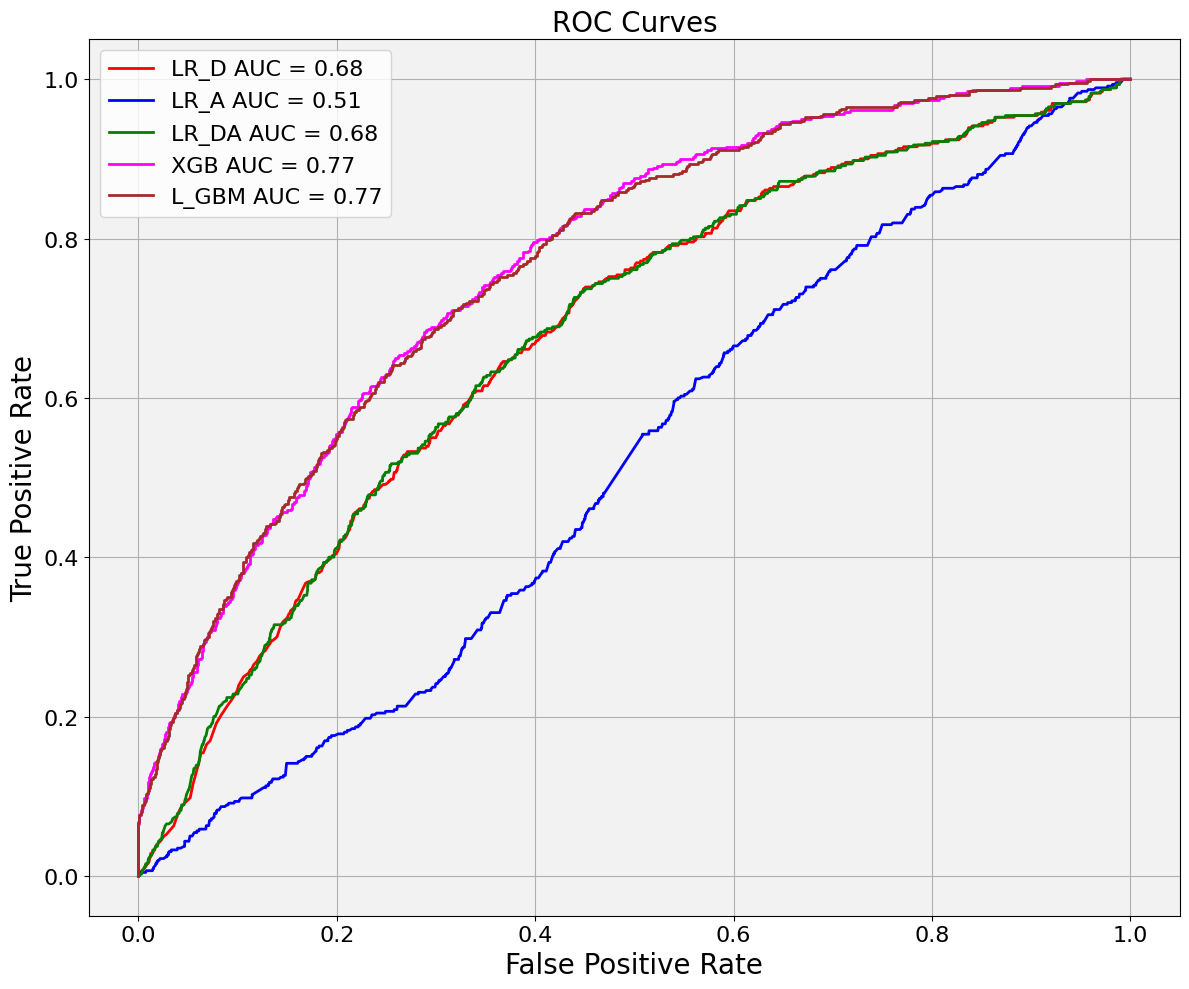

In [34]:
plot_roc_all_feat(X_test, y_test)

In [32]:
def plot_goal_rate_all_feat(X_test, y_test):  
    fig = plt.figure(figsize=(12,10))
    model_list = ['LR_D', 'LR_A', 'LR_DA', 'XGB', 'L_GBM'] 
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown']
    
    for i, model in enumerate(model_list):
        print(model)
        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test, model, "../model/")  
            df_percentile =  calc_percentile(pred_probs, y_test)
        else:
            file = open("../6_Different_Models/NN/results_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            df_percentile = calc_percentile(res["pred_probs"], y_test)

        goal_rate_df = goal_rate(df_percentile)
        goal_rate_x = goal_rate_df['Percentile']
        goal_rate_y = goal_rate_df['Rate']
        plot_color = model_color_list[i]
        plot_label = model_list[i]
        plt.plot(goal_rate_x,goal_rate_y, color = plot_color, label = f'{plot_label}' )
                 
       
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    
    ax.set_ylim([0,100])
    ax.set_xlim([0,100])
    ax.invert_xaxis()
    major_ticks = np.arange(0, 110, 10)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    
    plt.grid(True)
    plt.title('Goal Rate', fontsize=20)
    plt.xlabel('Shot probability model percentile', fontsize=16)
    plt.ylabel('Goals / (Shots+Goals)%', fontsize=16)
    plt.legend(loc=2,prop={'size': 16})
    plt.tight_layout()
    plt.savefig(f'../figures/Milestone_2/7-1-1b_goal_rates-playoff.png')
    plt.show()

LR_D
LR_A
LR_DA
XGB
L_GBM


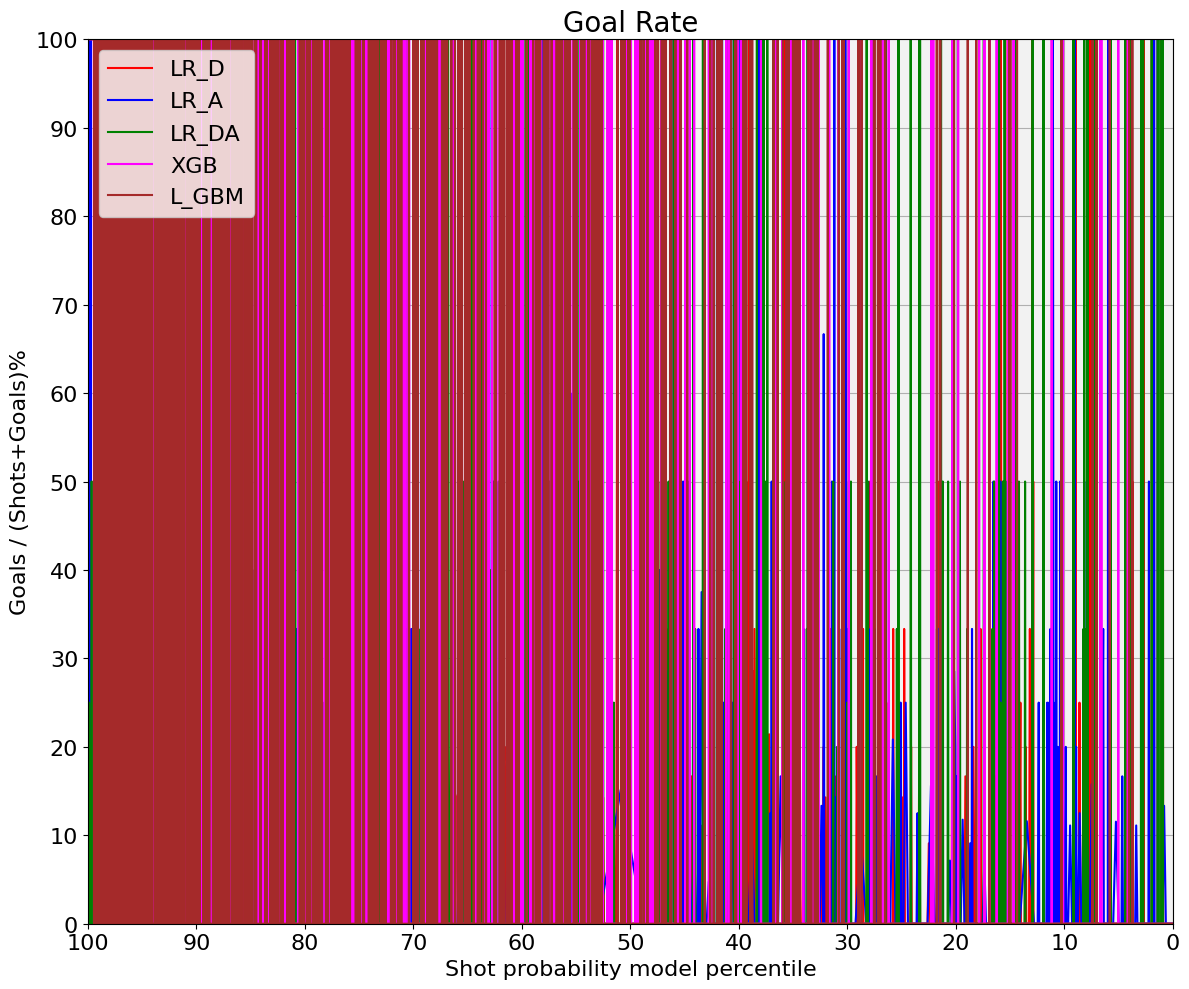

In [33]:
plot_goal_rate_all_feat(X_test, y_test)

In [35]:
def plot_cumulative_rate_all_feat(X_test, y_test):

    fig = plt.figure(figsize=(12,10))
    model_list = ['LR_D', 'LR_A', 'LR_DA', 'XGB', 'L_GBM'] 
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown']
    
    
    for i, model in enumerate(model_list):
        print(model)

        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test, model, "../model/") 
            df_percentile = calc_percentile(pred_probs, y_test)
        else:
            file = open("../6_Different_Models/NN/results_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            df_percentile = calc_percentile(res["pred_probs"], y_test)
            
        df_precentile_only_goal = df_percentile[df_percentile['isGoal'] == 1]
        
        plot_color = model_color_list[i]
        plot_label = model_list[i]
        ax = sns.ecdfplot(data=df_precentile_only_goal, x=100 - df_precentile_only_goal.Percentile, 
                              color=plot_color)
            
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(np.arange(0, 100 * 1.01, 10))
    xvals = ax.get_xticks()
    ax.set_xticklabels(100 - xvals.astype(np.int32), fontsize=16)
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(y) for y in yvals], fontsize=16)
    ax.set_xlabel('Shot probability model percentile', fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_title(f"Cumulative % of Goals", fontsize=20)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    
    plt.legend(labels=model_list, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'../figures/Milestone_2/7-1-1c_goal_proportions-playoff.png')
    plt.show()

LR_D
LR_A
LR_DA
XGB
L_GBM


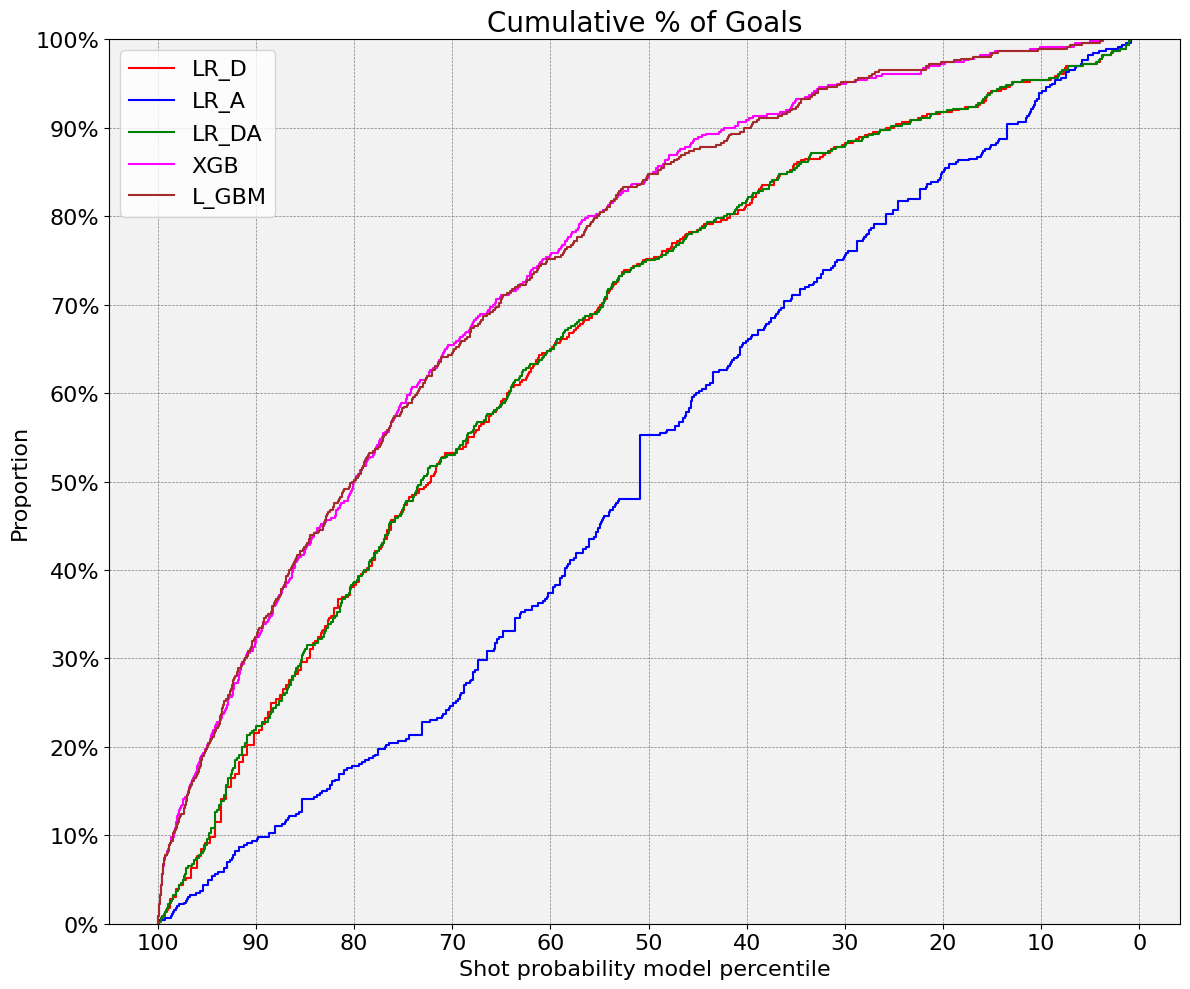

In [36]:
plot_cumulative_rate_all_feat(X_test, y_test)

In [37]:
def plot_calibration_all_feat(X_test, y_test):

    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 3)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    
    model_list = ['LR_D', 'LR_A', 'LR_DA', 'XGB', 'L_GBM'] 
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown', 'cyan', "orange", "yellow"]
    
    for i, model in enumerate(model_list):
        print(model)

        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test, model, "../model/")
            y_test_is_goal = y_test['isGoal']
            probs_isgoal = pred_probs[:,1]
        else:
            file = open("../6_Different_Models/NN/results_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            probs_isgoal = res["y_"]

        plot_color = model_color_list[i]
        plot_label = model_list[i] 
        ax_display = CalibrationDisplay.from_predictions(y_test_is_goal,probs_isgoal, n_bins=50,                                                           ax=ax_calibration_curve, color=plot_color, label=plot_label)
   
    ax = plt.gca()
    ax.set_facecolor('0.95')
    ax_calibration_curve.grid()
    
    plt.title("Calibration plots", fontsize=20)
    plt.legend(loc=2,prop={'size': 16})
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.ylabel('Fraction of positives', fontsize=20)
    plt.xlabel('Mean predicted probability', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'../figures/Milestone_2/7-1-1d_calibration_plots-playoff.png')
    plt.show()

LR_D
LR_A
LR_DA
XGB
L_GBM


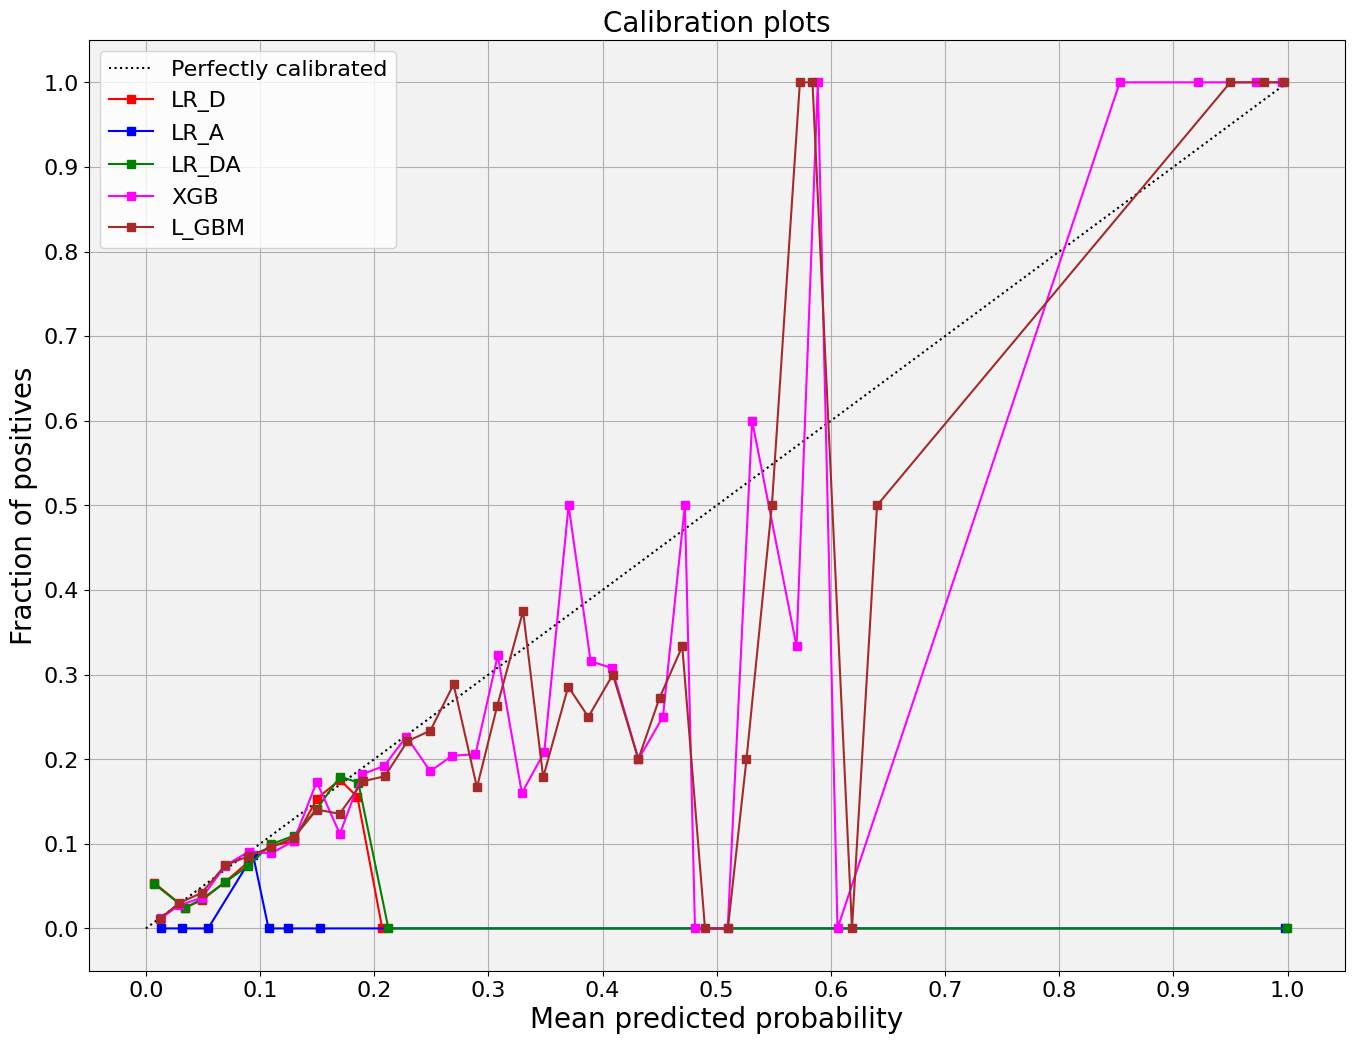

In [38]:
plot_calibration_all_feat(X_test, y_test)

In [12]:
def calc_percentile(pred_probs, y_val):
    
    # Créer un DataFrame pour les probabilités de tir
    df_probs = pd.DataFrame(pred_probs)
    df_probs = df_probs.rename(columns={0: "Probabilité_Non_But", 1: "Probabilité_But"})
    
    # Combiner la 'Probabilité de But' et 'Est But' dans un seul DataFrame
    df_probs = pd.concat([df_probs["Probabilité_But"].reset_index(drop=True), y_val["isGoal"].reset_index(drop=True)], axis=1)
    
    # Calculer et ajouter la colonne de Percentile
    valeurs_percentile = df_probs['Probabilité_But'].rank(pct=True)
    df_probs['Percentile'] = valeurs_percentile * 100
    df_percentile = df_probs.copy()
    
    return df_percentile


In [13]:
def goal_rate(df_percentile):
    """
    Calculate goal rates for each percentile group.
    """
    # Group by percentile and calculate mean goal rate
    goal_rate_df = df_percentile.groupby('Percentile').agg(
        Rate=('isGoal', 'mean')
    ).reset_index()

    # Convert to percentages if needed
    goal_rate_df['Rate'] *= 100
    return goal_rate_df
